This script is used to produce Figure 1D (map of Arctic bathymetry) afor the Payne et al. paper "End-of-century Arctic Ocean phytoplankton blooms start a month earlier due to anthropogenic climate change".

1. Import libraries

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cmocean
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors as c
import xesmf as xe

2. Read in DOC flux file. The thing we actually want from this file is the z_w_bot coordinate, which tells us the bottom of each grid cell in cm (thus the divide by 100).

In [2]:
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/ocn/proc/tseries/year_1/DIA_IMPVF_DOC/'
fnam = 'b.e21.BHISTsmbb.f09_g17.LE2-1301.012.pop.h.ecosys.nyear1.DIA_IMPVF_DOC.2001-2010.nc'

var = xr.open_dataset(fdir + fnam)
print(var['DIA_IMPVF_DOC'])
print(var['z_w_bot']/100)

<xarray.DataArray 'DIA_IMPVF_DOC' (time: 10, z_w_bot: 60, nlat: 384, nlon: 320)> Size: 295MB
[73728000 values with dtype=float32]
Coordinates:
  * z_w_bot  (z_w_bot) float32 240B 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
    ULONG    (nlat, nlon) float64 983kB ...
    ULAT     (nlat, nlon) float64 983kB ...
    TLONG    (nlat, nlon) float64 983kB ...
    TLAT     (nlat, nlon) float64 983kB ...
  * time     (time) object 80B 2001-01-01 00:00:00 ... 2010-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     DOC Flux Across Bottom Face from Diabatic Implicit Vertica...
    units:         mmol/m^3 cm/s
    grid_loc:      3113
    cell_methods:  time: mean
<xarray.DataArray 'z_w_bot' (z_w_bot: 60)> Size: 240B
array([  10.     ,   20.     ,   30.     ,   40.     ,   50.     ,
         60.     ,   70.     ,   80.     ,   90.     ,  100.     ,
        110.     ,  120.     ,  130.     ,  140.     ,  150.     ,
        160.     ,  170.19682,  180.76129,  191

3. Loop through all grid cells and all depths of the water column, setting the desired variable 'gcdep' (grid cell depth) to the bottom-most non-nan value.

In [ ]:
gcdep = np.zeros([384,320])
for i in np.arange(0,384):
    if i%20 == 0:
        print(i)
    for j in np.arange(0,320):
        for dep in np.arange(0,60):
            if np.isnan(var['DIA_IMPVF_DOC'][0,dep,i,j]) == False:
                gcdep[i,j] = var['z_w_bot'][dep]/100
            else:
                break

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360


4. Print out gcdep and open it up again, because step 3 takes forever!

In [5]:
dir = open("/glade/u/home/cpayne/Projects/PredictPerfect/Input/gridcelldepth.txt", "w")
for row in gcdep:
    np.savetxt(dir, row)
dir.close()

In [3]:
dir = np.loadtxt("/glade/u/home/cpayne/Projects/PredictPerfect/Input/gridcelldepth.txt")
gcdep = dir.reshape(384,320)


5. Make lon and lat variables that don't have weird holes in them

In [4]:
lon, lat = var.TLONG.values, var.TLAT.values #if in 'ice', use 'TLON', in 'ocn', use 'TLONG'

ok = ~np.isnan(lon)
xp = ok.ravel().nonzero()[0]
fp = lon[~np.isnan(lon)]
x  = np.isnan(lon).ravel().nonzero()[0]
lon[np.isnan(lon)] = np.interp(x, xp, fp)

ok = ~np.isnan(lat)
xp = ok.ravel().nonzero()[0]
fp = lat[~np.isnan(lat)]
x  = np.isnan(lat).ravel().nonzero()[0]
lat[np.isnan(lat)] = np.interp(x, xp, fp)

In [30]:
var.TLONG

<xarray.DataArray 'TLONG' (nlat: 384, nlon: 320)> Size: 983kB
array([[320.562509, 321.687509, 322.812509, ..., 317.187509, 318.312509,
        319.437509],
       [320.562509, 321.687509, 322.812509, ..., 317.187509, 318.312509,
        319.437509],
       [320.562509, 321.687509, 322.812509, ..., 317.187509, 318.312509,
        319.437509],
       ...,
       [320.251331, 320.753801, 321.255773, ..., 318.744245, 319.246217,
        319.748691],
       [320.234595, 320.703589, 321.172074, ..., 318.827943, 319.296428,
        319.765427],
       [320.216509, 320.64933 , 321.081635, ..., 318.918383, 319.350688,
        319.783513]])
Coordinates:
    ULONG    (nlat, nlon) float64 983kB ...
    ULAT     (nlat, nlon) float64 983kB ...
    TLONG    (nlat, nlon) float64 983kB 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 983kB -79.22 -79.22 -79.22 ... 72.19 72.19
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  array of t-grid longitudes
    units:      degrees_east

In [28]:
# a. Read in a shapefile of the sea ice masks (perennial ice, seasonal ice, open water)
# load the xarray lat/lon files from pop grid
TLONG = var.TLONG
TLAT = var.TLAT

# Rename TLON and TLAT coordinates to be lon and lat so we can join them with sea ice data
TLONG = TLONG.rename({'nlon':'lon','nlat':'lat'})
TLAT =  TLAT.rename({'nlon':'lon','nlat':'lat'})


In [33]:
ds = xr.Dataset(
    data_vars=dict(
        DEP=(["lat", "lon"], gcdep),
    ),
    coords=dict(
        TLON=(["lat", "lon"], TLONG.data),
        TLAT=(["lat", "lon"], TLAT.data),
    ),
)

In [35]:
ds['DEP'] = ds['DEP'].rename({'TLON':'lon','TLAT':'lat'})


In [36]:
# Setting up a target grid 
# Do not include 90N and 90S otherwise cartopy gets rage-y (i.e. it doesn't work) when plotting
lat_new = np.arange(-89.5,90.0,0.5) 
lon_new = np.arange(0.0,361.0,1.0)

#create a meshgrid (2D fields of lats and lons)
lon2d,lat2d=np.meshgrid(lon_new,lat_new) 
#set up the target grid as an xarray Dataset
target_grid=xr.Dataset({'lat': (['y', 'x'], lat2d),'lon': (['y', 'x'], lon2d)})

#input grid, output grid, method, keyword arguments
regridder = xe.Regridder(ds['DEP'], target_grid, 'nearest_s2d',periodic=True,reuse_weights=False)

# actually do the regridding
gcdep_regrid = regridder(ds['DEP'])


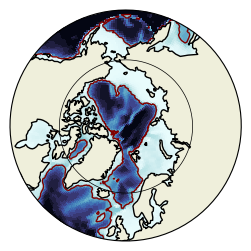

In [43]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# set figure basics (size, projection)
# fig = plt.figure(figsize=(3.5,3.5)) 
fig = plt.figure(figsize=(3,3)) 
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());

# add the Arctic Circle
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=.5, color='black')
gl.ylocator = mticker.FixedLocator([66.5])
gl.xlocator = mticker.FixedLocator([])

# plot the variable of interest (ocean depth)
pc = ax.pcolormesh(lon, lat, -gcdep, 
                   transform=ccrs.PlateCarree(), vmin = -4000, vmax = 0,  #-60 60, -20 20
                   cmap='cmo.ice', zorder = 1); 

this1=ax.contour(lon2d,lat2d,gcdep_regrid, levels = np.arange(1000,1050,50),
                 colors=['maroon'],linestyles='solid', linewidths=1,
                 transform=ccrs.PlateCarree(),zorder=1)    
# add coastlines and colorbar
ax.coastlines();  ax.add_feature(cfeature.LAND, zorder = 1); 
# cbar = fig.colorbar(pc, ticks = [-4000,-3000,-2000,-1000,0], extend='min')
# cbar.ax.set_yticklabels(['4', '3', '2', '1', '0'])

# print out figure
figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/Fig1d.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()

In [48]:
# i = 322; j = 193; # Bering
# i = 342; j = 194; # Chukchi
# i = 341; j = 275; # Hudson
i = 372; j = 176; # Central
gcdep[i,j]

1482.90078125